<a href="https://colab.research.google.com/github/Pacoanes/State-of-the-art/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [417]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append("..")
import download_utils
import tqdm_utils
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [0]:
def detect_faces(cascade, test_image, scaleFactor = 1.1):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = test_image.copy()

    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

    # Applying the haar classifier to detect faces
    faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=3)
    
    if (faces_rect==()):
      return 0
    else:
      
      for (x, y, w, h) in faces_rect:
        #cv2.rectangle(image_copy, (x-20, y-30), (x+w+30, y+h+30), (0, 255, 0), 2)    
        r = max(w, h) / 1.3
        centerx = x + w / 2
        centery = y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)
      faceimg = image_copy[ny:ny+nr, nx:nx+nr]

      return faceimg

In [0]:
haar_cascade_face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [421]:
  
"""test_image2 = cv2.imread('kalo1886.jpg')
test_image_color = cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB)
faces = detect_faces(haar_cascade_face, test_image_color)
plt.imshow(faces);"""

"test_image2 = cv2.imread('kalo1886.jpg')\ntest_image_color = cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB)\nfaces = detect_faces(haar_cascade_face, test_image_color)\nplt.imshow(faces);"

In [425]:
drive.mount("/content/drive", force_remount=True)
path = "/content/drive/My Drive/ban/raw"
training_data = []
for img in os.listdir(path):  
    try:
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        faces = detect_faces(haar_cascade_face, img_rgb)
        new_array = cv2.resize(faces, (100, 100))
        training_data.append(new_array)
    except Exception as e:  
        pass
print(len(training_data))



Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


2559


[array([[[238, 185, 117],
         [234, 183, 117],
         [244, 188, 115],
         ...,
         [251, 214, 145],
         [248, 212, 150],
         [243, 205, 134]],
 
        [[236, 183, 115],
         [235, 184, 118],
         [240, 186, 113],
         ...,
         [247, 210, 141],
         [249, 211, 148],
         [242, 204, 133]],
 
        [[235, 182, 114],
         [234, 183, 117],
         [236, 183, 110],
         ...,
         [246, 209, 140],
         [244, 204, 142],
         [243, 205, 134]],
 
        ...,
 
        [[101,  92,  75],
         [106,  97,  75],
         [136, 117,  82],
         ...,
         [235, 188, 134],
         [232, 188, 137],
         [227, 180, 124]],
 
        [[122, 107,  80],
         [153, 140, 107],
         [207, 183, 141],
         ...,
         [221, 163, 104],
         [222, 169, 114],
         [224, 167, 108]],
 
        [[195, 175, 138],
         [221, 201, 156],
         [235, 207, 172],
         ...,
         [238, 182, 122],
  

In [440]:
datta=training_data[0]
datta.shape

(100, 100, 3)

In [443]:
training_dat = np.float32(datta)/255.
len(training_data)

2559

In [437]:
IMG_SHAPE_ban=training_dat.shape
IMG_SHAPE_ban

(100, 100, 3)

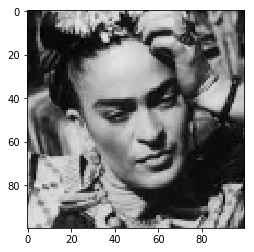

In [484]:
plt.imshow(training_data[np.random.randint(len(training_data))], cmap="gray", interpolation="none")

In [0]:
#librerias para GAN
import tensorflow as tf
from keras_utils import reset_tf_session
s = reset_tf_session()
import keras
from keras.models import Sequential
from keras import layers as L

In [0]:
#red generadora
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(18*8*8, activation='elu'))
generator.add(L.Reshape((8,8,18)))
generator.add(L.Deconv2D(32,kernel_size=(6,6),activation='elu'))
generator.add(L.Deconv2D(32,kernel_size=(6,6),activation='elu'))
generator.add(L.UpSampling2D(size=(8,8)))
generator.add(L.Deconv2D(16,kernel_size=4,activation='elu'))
generator.add(L.Deconv2D(16,kernel_size=4,activation='elu'))
generator.add(L.Deconv2D(16,kernel_size=4,activation='elu'))
generator.add(L.Conv2D(3,kernel_size=4,activation=None))

generator.summary()

W0802 11:56:44.389688 139646635067264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1152)              296064    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 18)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 32)        20768     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 18, 18, 32)        36896     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 144, 144, 32)      0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 147, 147, 16)      8208      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 150, 150, 16)      4112      
__________

In [0]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE_ban))

discriminator.add(L.Conv2D(16, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.Conv2D(16, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))

discriminator.add(L.Conv2D(32, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.Conv2D(32, kernel_size=3))
discriminator.add(L.BatchNormalization())
discriminator.add(L.advanced_activations.LeakyReLU(alpha=.1))

discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))


# <build discriminator body>

discriminator.add(L.Flatten())
discriminator.add(L.Dense(128,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


discriminator.summary()

W0802 11:56:48.182219 139646635067264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0802 11:56:48.333504 139646635067264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 146, 146, 16)      2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 146, 146, 16)      64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 146, 146, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 16)        0         
__________

In [0]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE_ban))

logp_real = discriminator(real_data)

generated_data = generator(noise) #<gen(noise)>

logp_gen = discriminator(generated_data) #<log P(real | gen(noise))




In [0]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
 
disc_optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

W0802 11:56:53.078509 139646635067264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
########################
###generator training###
########################

g_loss = tf.reduce_mean(logp_gen[:,0]) # <generator loss>

gen_optimizer =tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)
    

In [0]:
s.run(tf.global_variables_initializer())

In [0]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(training_dat.shape[0]), size=bsize)
    return training_dat[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(training_dat),np.max(training_dat))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE_ban),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE_ban),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

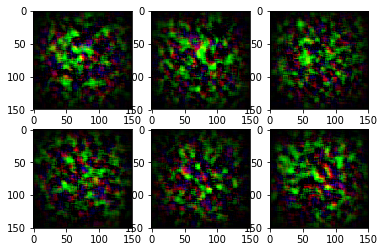

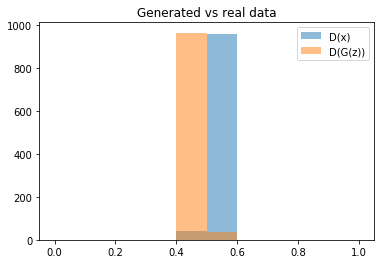

  0%|          | 62/50000 [02:41<33:53:29,  2.44s/it]

KeyboardInterrupt: ignored

In [0]:
from IPython import display
from tqdm import tqdm
for epoch in tqdm(range(50000)):
  
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
  
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
  
    s.run(gen_optimizer,feed_dict)
  
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)

In [0]:
plt.figure(figsize=[16,24])
sample_images(16,8)